### 9.1 Diffusion - Hat vs No Hat CLIP Example 
Reproduces results in Figure 9.8

In [1]:
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [4]:
def get_common_objects_and_concepts():
    """Curated list of common objects, animals, concepts, emotions, etc."""
    categories = {
        'objects': [
            'chair', 'table', 'car', 'bicycle', 'bottle', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'pizza',
            'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard',
            'cell phone', 'book', 'clock', 'scissors', 'teddy bear', 'hair dryer',
            'toothbrush', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
            'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'man', 'woman'
        ],
        'animals': [
            'person', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
            'giraffe', 'bird', 'chicken', 'duck', 'eagle', 'owl', 'fish', 'shark', 'whale',
            'dolphin', 'turtle', 'frog', 'snake', 'spider', 'bee', 'butterfly', 'lion',
            'tiger', 'fox', 'wolf', 'rabbit', 'hamster', 'mouse', 'rat'
        ],
        'clothing': [
            'hat', 'cap', 'helmet', 'glasses', 'sunglasses', 'shirt', 't-shirt', 'sweater',
            'jacket', 'coat', 'dress', 'skirt', 'pants', 'jeans', 'shorts', 'shoes',
            'sneakers', 'boots', 'sandals', 'socks', 'tie', 'scarf', 'gloves', 'belt',
            'watch', 'ring', 'necklace', 'earrings', 'bracelet'
        ],
        'emotions': [
            'happy', 'sad', 'angry', 'surprised', 'excited', 'calm', 'peaceful', 'joyful',
            'melancholy', 'nostalgic', 'anxious', 'confident', 'mysterious', 'dramatic',
            'romantic', 'energetic', 'serene', 'tense', 'playful', 'serious'
        ],
        'abstract_concepts': [
            'freedom', 'justice', 'peace', 'war', 'love', 'hate', 'beauty', 'ugliness',
            'truth', 'lie', 'innovation', 'tradition', 'progress', 'chaos', 'order',
            'simplicity', 'complexity', 'elegance', 'roughness', 'sophistication'
        ],
        'colors': [
            'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown',
            'black', 'white', 'gray', 'silver', 'gold', 'cyan', 'magenta', 'lime',
            'navy', 'maroon', 'olive', 'aqua'
        ],
        'styles': [
            'modern', 'vintage', 'classic', 'contemporary', 'abstract', 'realistic',
            'minimalist', 'ornate', 'rustic', 'elegant', 'casual', 'formal', 'artistic',
            'professional', 'creative', 'traditional', 'futuristic', 'retro'
        ],
        'activities': [
            'running', 'walking', 'jumping', 'dancing', 'singing', 'reading', 'writing',
            'cooking', 'eating', 'sleeping', 'working', 'playing', 'studying', 'exercising',
            'swimming', 'flying', 'driving', 'riding', 'climbing', 'surfing'
        ]
    }
    
    # Flatten all categories
    all_concepts = []
    for category, items in categories.items():
        if category == "objects":
            items = ['A photo of a ' + w for w in items]
        all_concepts.extend(items)
    
    return all_concepts, categories

In [5]:
words, categories=get_common_objects_and_concepts()
len(words)

208

In [6]:
image = Image.open('data/me_with_hat.jpeg')
image_2 = Image.open('data/me_no_hat_cropped_1.jpeg')

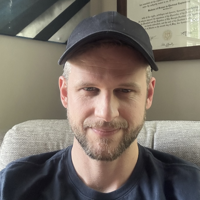

In [7]:
image.resize((200,200)) #Display smaller version

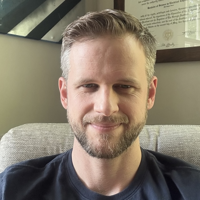

In [8]:
image_2.resize((200,200))

In [9]:
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    image_features = model.get_image_features(**inputs)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

inputs_2 = processor(images=image_2, return_tensors="pt").to(device)
with torch.no_grad():
    image_features_2 = model.get_image_features(**inputs_2)
    image_features_2 = image_features_2 / image_features_2.norm(dim=-1, keepdim=True)

In [10]:
inputs = processor(text=words[0], return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

In [11]:
batch_size=1024
all_text_features=[]
for i in tqdm(range(int(np.ceil(len(words)/batch_size)))):
    inputs = processor(text=words[i*batch_size:(i+1)*batch_size], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        # Normalize the embeddings
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        all_text_features.append(text_features)
all_text_features=torch.concat(all_text_features)

100%|██████████████████████████████████████████████| 1/1 [00:00<00:00, 70.93it/s]


In [12]:
all_text_features.shape

torch.Size([208, 512])

In [13]:
similarities = torch.cosine_similarity(image_features-image_features_2, all_text_features, dim=1)

In [14]:
similarities.shape

torch.Size([208])

In [15]:
top_k=10
top_k_indices = similarities.argsort(descending=True)[:top_k]

results = []
for idx in top_k_indices:
    results.append({
        'text': words[idx],
        'similarity': similarities[idx].item()
    })
results

[{'text': 'hat', 'similarity': 0.16496598720550537},
 {'text': 'cap', 'similarity': 0.11361426115036011},
 {'text': 'helmet', 'similarity': 0.10564661771059036},
 {'text': 'angry', 'similarity': 0.060973454266786575},
 {'text': 'tense', 'similarity': 0.05931840464472771},
 {'text': 'exercising', 'similarity': 0.057576026767492294},
 {'text': 'roughness', 'similarity': 0.05686981976032257},
 {'text': 'hate', 'similarity': 0.0565527081489563},
 {'text': 'A photo of a frisbee', 'similarity': 0.05526324361562729},
 {'text': 'A photo of a tennis racket', 'similarity': 0.05416693538427353}]

### 9.2 CLIP - Cat Classification Example
Reproduces results from Figure 9.9

In [16]:
def get_common_objects_and_concepts():
    """Curated list of common objects, animals, concepts, emotions, etc."""
    categories = {
        'objects': [
            'chair', 'table', 'car', 'bicycle', 'bottle', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'pizza',
            'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard',
            'cell phone', 'book', 'clock', 'scissors', 'teddy bear', 'hair dryer',
            'toothbrush', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
            'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'man', 'woman'
        ],
        'animals': [
            'person', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
            'giraffe', 'bird', 'chicken', 'duck', 'eagle', 'owl', 'fish', 'shark', 'whale',
            'dolphin', 'turtle', 'frog', 'snake', 'spider', 'bee', 'butterfly', 'lion',
            'tiger', 'fox', 'wolf', 'rabbit', 'hamster', 'mouse', 'rat'
        ],
        'clothing': [
            'hat', 'cap', 'helmet', 'glasses', 'sunglasses', 'shirt', 't-shirt', 'sweater',
            'jacket', 'coat', 'dress', 'skirt', 'pants', 'jeans', 'shorts', 'shoes',
            'sneakers', 'boots', 'sandals', 'socks', 'tie', 'scarf', 'gloves', 'belt',
            'watch', 'ring', 'necklace', 'earrings', 'bracelet'
        ]
    }
    
    # Flatten all categories
    all_concepts = []
    for category, items in categories.items():
        if category == "objects":
            items = ['A photo of a ' + w for w in items]
        all_concepts.extend(items)
    
    return all_concepts, categories

In [17]:
words, categories=get_common_objects_and_concepts()

In [18]:
image = Image.open('data/n02123045_1955.jpg')

inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    image_features = model.get_image_features(**inputs)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

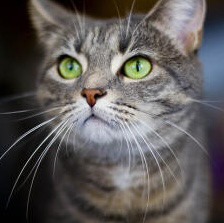

In [19]:
image

In [20]:
all_text_features=[]
for i, word in enumerate(words):
    inputs=processor(text='A photo of a '+ word, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        all_text_features.append(text_features)
all_text_features=torch.concat(all_text_features)

In [21]:
all_text_features.shape

torch.Size([110, 512])

In [22]:
similarities = torch.cosine_similarity(image_features, all_text_features, dim=1)

In [23]:
similarities.shape

torch.Size([110])

In [24]:
top_k = 16
top_k_indices = similarities.argsort(descending=True)[:top_k]

results = []
for idx in top_k_indices:
    print(words[idx], similarities[idx].item())


cat 0.2783862054347992
tiger 0.23955842852592468
socks 0.23531195521354675
mouse 0.23520846664905548
boots 0.23442256450653076
person 0.2292843461036682
rat 0.22281545400619507
necklace 0.22178848087787628
sneakers 0.2213522344827652
dog 0.22083759307861328
rabbit 0.21997985243797302
cap 0.2162446528673172
tie 0.2161935567855835
sweater 0.21580779552459717
t-shirt 0.215627059340477
owl 0.21527116000652313
